# Task 04 - Sepsis Detection

Débora Mayumi Rissato - 5288223

Douglas Decicino de Andrade - 10883512

Paulino Ribeiro Villas Boas - 2950178

Renan Silva Chun - 10691817

Renan de Oliveira da Cruz - 10801090

Abaixo temos o import de algumas bibliotecas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate,
                                     train_test_split, GridSearchCV,
                                     LeaveOneOut, KFold, StratifiedKFold,
                                     cross_val_score)

from sklearn.metrics import (classification_report, balanced_accuracy_score,
                             precision_score, roc_auc_score, accuracy_score,
                             f1_score, confusion_matrix,classification_report,roc_curve,precision_recall_curve)
import traceback
import re
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import string
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import random

## Tratamento da base 

Importando os dados

In [2]:
test = pd.read_csv('../input/task-04/test_data_without_label.csv')
dados = pd.read_csv('../input/task-04/training_data.csv')

Proporção de casos positivos de Sepse nos dados de treinamento.

In [3]:
sepsis_ratio = dados['sepse'].value_counts()
print(sepsis_ratio)
sepsis_ratio = sepsis_ratio[1] / sepsis_ratio.sum()
print(sepsis_ratio)

0    14374
1     2575
Name: sepse, dtype: int64
0.15192636733730602


Nota-se que o dataset apresenta alto grau de desbalanceamento.

Proporção de valores ausentes para cada variável.

In [4]:
dados.isnull().mean().sort_values(ascending = False)

respiracao     0.810313
pa_max         0.499616
pa_min         0.499498
pulso          0.161425
temperatura    0.126556
id             0.000000
num_atend      0.000000
sepse          0.000000
dtype: float64

A partir do output acima notamos que, nos dados de treinamento, a variável "respiração" contém cerca de 80% de valores ausentes. Sendo assim, optamos por excluir essa variável do dataset em razão da número de valores ausentes.

In [5]:
dados.drop(columns = "respiracao", inplace = True)
test.drop(columns = "respiracao", inplace = True)

Abaixo, construimos algumas funções que corrigem valores que acreditamos ter sido preenchidos errôneamente. Correções como por exemplo:


*   Possiveis erros de digitação (valores "muito altos" e "muito baixos" para a variável observada). Acreditamos que o usuário digitou ou um zero a mais ou um a menos em alguns casos;
*   Para variáveis como temperatura, pulso, e PA min e max, substituimos valores igual a 0 por NAN's, pois este valor para estas variáveis não faz sentido.



In [6]:
def corrigePulso(df, isTest = False):
    
    if isTest:
        sns.boxplot(y = df["pulso"])
        plt.title("Box Plot para a variável Pulso - Antes de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["pulso"])
        plt.title("Box Plot para a variável Pulso - Antes de Modificar")
        plt.show()
        
    indices = df['pulso'].between(600,2000)
    df.loc[indices,'pulso'] = df.loc[indices,'pulso']/10
    indices = df['pulso'] == 0
    df.loc[indices,'pulso'] = np.nan
    indices = df['pulso'].between(0,15)
    df.loc[indices,'pulso'] = df.loc[indices,'pulso']*10
    
    if isTest:
        sns.boxplot(y = df["pulso"])
        plt.title("Box Plot para a variável Pulso - Depois de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["pulso"])
        plt.title("Box Plot para a variável Pulso - Depois de Modificar")
        plt.show()
    
    return df

def corrigeTemperatura(df, isTest = False):
    
    if isTest:
        sns.boxplot(y = df["temperatura"])
        plt.title("Box Plot para a Temperatura - Antes de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["temperatura"])
        plt.title("Box Plot para a Temperatura - Antes de Modificar")
        plt.show()
    
    indices = df["temperatura"].between(300,400)
    df.loc[indices,"temperatura"] = df.loc[indices,"temperatura"]/10
    indices = df["temperatura"]>3000
    df.loc[indices,"temperatura"] = df.loc[indices,"temperatura"]/100
    df.loc[df["temperatura"].between(41,299),"temperatura"] = np.nan
    indices = df["temperatura"]<0
    df.loc[indices,"temperatura"] = -df.loc[indices,"temperatura"]
    indices = df["temperatura"].between(0,30)
    df.loc[indices,"temperatura"] = np.nan

    if isTest:
        sns.boxplot(y = df["temperatura"])
        plt.title("Box Plot para a Temperatura - Depois de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["temperatura"])
        plt.title("Box Plot para a Temperatura - Depois de Modificar")
        plt.show()
    
    return df

def corrigePA(df, isTest = False):
    
    if isTest:
        sns.boxplot(y = df["pa_min"])
        plt.title("Box Plot para a Pressão Arterial Min - Antes de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["pa_min"])
        plt.title("Box Plot para a Pressão Arterial Min - Antes de Modificar")
        plt.show()
        
        
    if isTest:
        sns.boxplot(y = df["pa_max"])
        plt.title("Box Plot para a Pressão Arterial max - Antes de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["pa_max"])
        plt.title("Box Plot para a Pressão Arterial max - Antes de Modificar")
        plt.show()
    
    # Provavelmente erro de digitação MIN
    df.loc[df.loc[:, "pa_min"] > 300, "pa_min"] = df.loc[df.loc[:, "pa_min"] > 300, "pa_min"]/10
    
    # Provavelmente erro de digitação MIN
    df.loc[df.loc[:, "pa_min"] < 20, "pa_min"] = df.loc[df.loc[:, "pa_min"] < 20, "pa_min"]*10
    
    # Provavelmente erro de digitação MAX
    df.loc[df.loc[:, "pa_max"] > 300, "pa_max"] = df.loc[df.loc[:, "pa_max"] > 300, "pa_max"]/10
    
    # Provavelmente erro de digitação MAX
    df.loc[df.loc[:, "pa_min"] < 20, "pa_max"] = df.loc[df.loc[:, "pa_max"] < 20, "pa_max"]*10
    
    
    # Percebemos que de um modo geral as observações relacionadas ao PA_MAX são menores do que as
    # observações relacionadas ao PA_MIN. Acreditamos que isso possa ser um erro na hora de nomear
    # as colunas. Assim, como isso ocorre de maneira global, decidimos continuar fazendo da maneira
    # que está nomeado.
    # A única inconsistencia é todas as observações do PA_MAX tem que ser menores do que que todas
    # as observações do PA_MAX.
    # Nas linhas abaixo fazemos essa alteração.
    if sum(df['pa_min'] < df['pa_max']) > 0:
        indices = df[df['pa_min'] < df['pa_max']].index
        for ind in indices:
            aux = df.loc[ind, "pa_min"]
            df.loc[ind, "pa_min"] = df.loc[ind, "pa_max"]
            df.loc[ind, "pa_max"] = aux
    
    # dados considerados como "normais", isto é, não é erro de digitação
    indices = df["pa_min"].between(20,300)
    indices = indices == False # onde tá True coloco False e onde está False coloco True
    
    df.loc[indices, "pa_min"] = np.nan
    
    # dados considerados como "normais", isto é, não é erro de digitação
    indices = df["pa_max"].between(20,300)
    indices = indices == False # onde tá True coloco False e onde está False coloco True
    
    df.loc[indices, "pa_max"] = np.nan
     
    if isTest:
        sns.boxplot(y = df["pa_min"])
        plt.title("Box Plot para a Pressão Arterial Min - Depois de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["pa_min"])
        plt.title("Box Plot para a Pressão Arterial Min - Depois de Modificar")
        plt.show()

    if isTest:
        sns.boxplot(y = df["pa_max"])
        plt.title("Box Plot para a Pressão Arterial Max - Depois de Modificar")
        plt.show()
    else:
        sns.boxplot(x = df["sepse"], y = df["pa_max"])
        plt.title("Box Plot para a Pressão Arterial Max - Depois de Modificar")
        plt.show() 
        
    return df

Agora, aplicamos as funções criadas nos dados.

### Dados de Treinamento

Abaixo, temos então a correção das variáveis para o conjunto de treino, assim como os plots de antes e depois destas correções (já implementados nas funções).

* Correção da variável Pulso

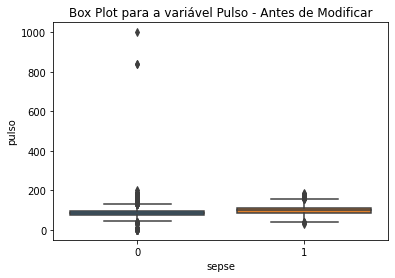

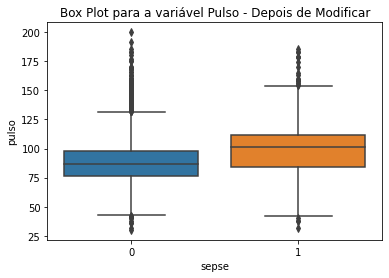

In [7]:
dados = corrigePulso(dados)

Percebemos, mediante o gráfico acima que mesmo após a correção de alguns valores tem-se a presença de outliers.

* Correção da variável Temperatura

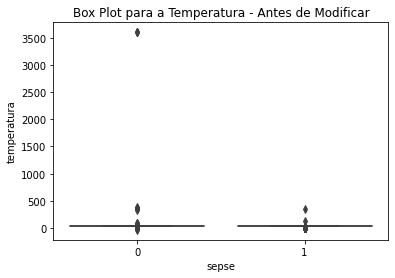

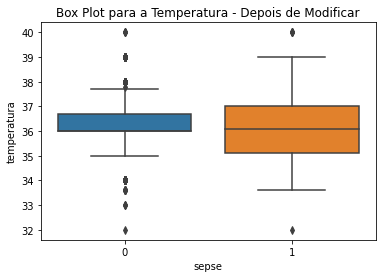

In [8]:
dados = corrigeTemperatura(dados)

Destaca-se que consideramos o os valores de 0 a 30 da variavel temperatura como sendo um valor ausente.

- Correção das variáveis de pressão arterial

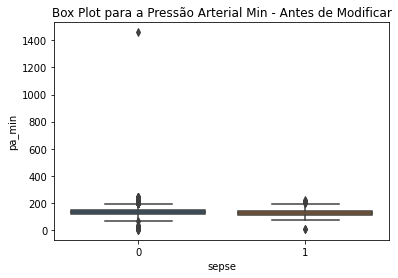

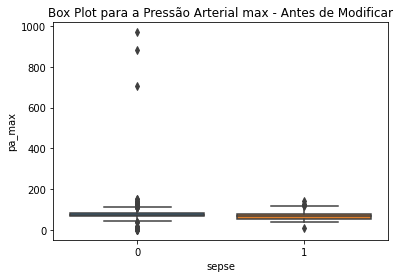

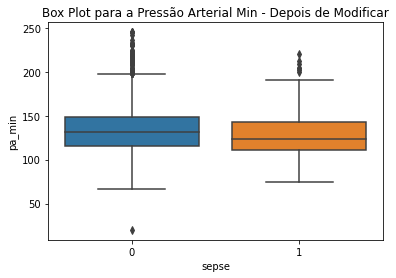

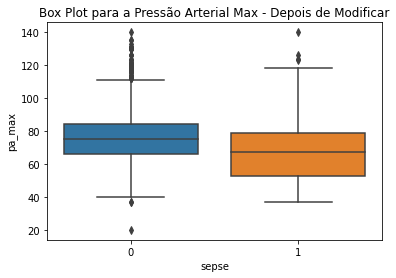

In [9]:
dados = corrigePA(dados)

### Dados de Teste

Abaixo, temos então a correção das variáveis para o conjunto de teste, assim como os plots de antes e depois destas correções (já implementados nas funções).

* Correção da variável Pulso

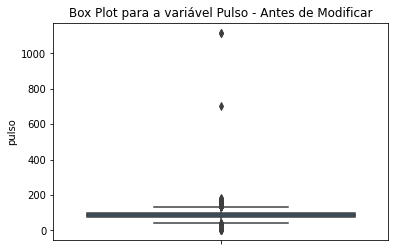

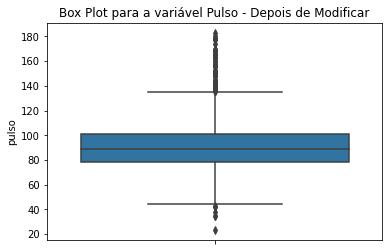

In [10]:
test = corrigePulso(test, isTest = True)

* Correção da variável Temperatura

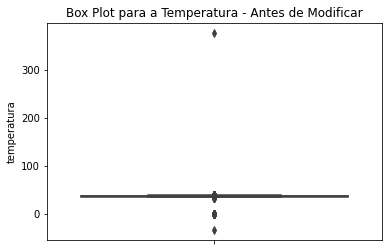

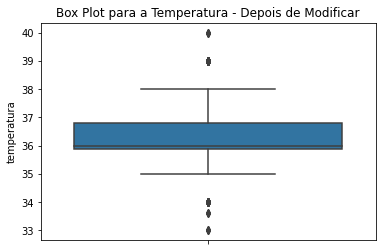

In [11]:
test = corrigeTemperatura(test, isTest = True)

* Correção das variáveis de pressão arterial

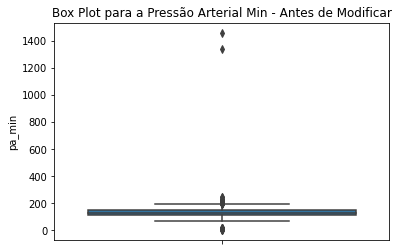

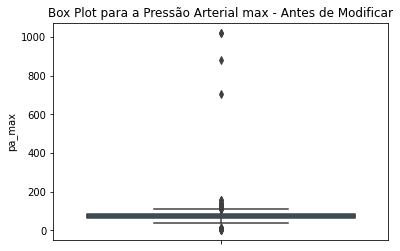

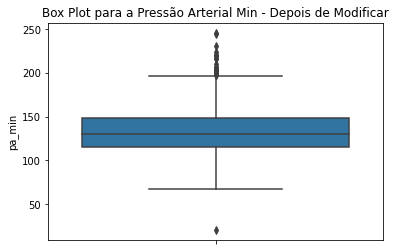

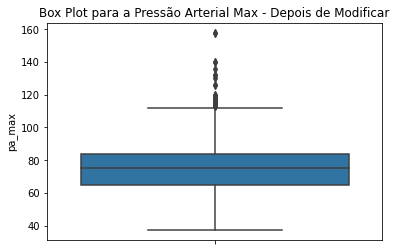

In [12]:
test = corrigePA(test, isTest = True)

Vejemos agora a proporção de valores ausentes.

In [13]:
dados.isnull().mean().sort_values(ascending = False)

pa_max         0.500561
pa_min         0.499616
pulso          0.162251
temperatura    0.138297
id             0.000000
num_atend      0.000000
sepse          0.000000
dtype: float64

Substituímos os valores ausentes pela mediana 

In [14]:
def sub_na(df):
    df['temperatura'].fillna(df['temperatura'].median(), inplace=True)
    df['pulso'].fillna(df['pulso'].median(), inplace=True)
    df['pa_min'].fillna(df['pa_min'].median(), inplace=True)
    df['pa_max'].fillna(df['pa_max'].median(), inplace=True)
    
    return df

In [15]:
test = sub_na(test)
dados = sub_na(dados)
dados.isnull().mean().sort_values(ascending = False)

id             0.0
num_atend      0.0
temperatura    0.0
pulso          0.0
pa_min         0.0
pa_max         0.0
sepse          0.0
dtype: float64

In [16]:
X = np.array(dados.loc[:, ['temperatura', 'pulso', 'pa_min', 'pa_max']])
y = np.array(dados.loc[:, 'sepse'])

## Ajustes e validação dos modelos.

### Naive Bayes

In [17]:
model = GaussianNB()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=7)
scores = cross_val_score(model, X, y, scoring = 'balanced_accuracy', cv = cv, n_jobs=-1)
print("Acurácia média: ", np.mean(scores),"Desvio padrão acurácia: " ,np.std(scores))

Acurácia média:  0.621680409328438 Desvio padrão acurácia:  0.014286938038976758


### Ada boosting

In [18]:
# hiperparametros para ajustar
param_grid = {
    'n_estimators': [500,600],
    'learning_rate': [0.1,1]
}

gs_ab = GridSearchCV(AdaBoostClassifier(), param_grid = param_grid, n_jobs=-1, scoring = "balanced_accuracy")
gs_ab.fit(X,y)

print('Melhores parâmetros:', gs_ab.best_params_)

Melhores parâmetros: {'learning_rate': 1, 'n_estimators': 600}


In [19]:
model = AdaBoostClassifier(n_estimators=gs_ab.best_params_["n_estimators"], learning_rate = gs_ab.best_params_["learning_rate"], algorithm='SAMME')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
print("Acurácia média: ", np.mean(scores),"Desvio padrão acurácia: " ,np.std(scores))

Acurácia média:  0.5929343975855006 Desvio padrão acurácia:  0.01312748996761386


### XgBoost

In [20]:
# hiperparametros para ajustar
param_grid = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [4, 5]
        }

gs_ab = GridSearchCV(XGBClassifier(), param_grid = param_grid, n_jobs=-1, scoring = "balanced_accuracy")

gs_ab.fit(X,y)

print('Melhores parâmetros:', gs_ab.best_params_)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:37:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Melhores parâmetros: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}


In [21]:
model = XGBClassifier(colsample_bytree = gs_ab.best_params_['colsample_bytree'], gamma = gs_ab.best_params_['gamma'],
                      max_depth = gs_ab.best_params_['max_depth'], min_child_weight= gs_ab.best_params_['min_child_weight'],  subsample = gs_ab.best_params_['subsample'] )

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
print("Acurácia média: ", np.mean(scores),"Desvio padrão acurácia: " ,np.std(scores))

Acurácia média:  0.6462468588771311 Desvio padrão acurácia:  0.007787651852533425


Podemos observar então, que o modelo que obteve a maior acurácia balanceada foi o modelo XGBClassifier, portanto iremos utilizar ele para os próximos passos.

## Achando a melhor probabilidade de corte.

Como temos um desbalanceamento consideranvelmente grande em relação as observações das classes, uma boa técnica que promete melhorar a performace do nosso modelo é encontrar a probabilidade de corte que maximiza a nossa métrica de validação escolhida. Para isso, vamos utilizar a curva ROC.

- Função para encontrar o threshold ideal para classificação binária:
     * modelo: um objeto de modelo treinado (como xgboost, glmnet, ...)
     *X: o conjunto de teste (pandas dataframe ou numpy array)
     *y_true: os rótulos verdadeiros da classe (lista ou matriz de 0's e 1's)

In [22]:
def _threshold_finder(model, X, y_true):
      
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return youden_threshold

Vamos então agora separar nossos dados em treino e teste para realizar o cálculo da melhor probabilidade de corte.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 1367, stratify = y)

In [24]:
fitted_model = XGBClassifier(colsample_bytree = gs_ab.best_params_['colsample_bytree'], gamma = gs_ab.best_params_['gamma'],
                      max_depth = gs_ab.best_params_['max_depth'], 
                             min_child_weight= gs_ab.best_params_['min_child_weight'],  
                             subsample = gs_ab.best_params_['subsample'] ).fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


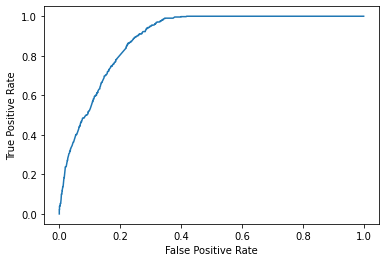

Temos então, que a melhor probabilidade de corte para o nosso problema é :  0.12365853 E abaixo temos também a curva ROC


In [25]:
best_treshold = _threshold_finder(model = fitted_model, X = X_test, y_true = y_test)
print("Temos então, que a melhor probabilidade de corte para o nosso problema é : ",best_treshold,"E abaixo temos também a curva ROC")

In [26]:
model = XGBClassifier(colsample_bytree = gs_ab.best_params_['colsample_bytree'], gamma = gs_ab.best_params_['gamma'],
                      max_depth = gs_ab.best_params_['max_depth'], 
                             min_child_weight= gs_ab.best_params_['min_child_weight'],  
                             subsample = gs_ab.best_params_['subsample'])

cv = StratifiedKFold(n_splits=10)
acc = list()
for train_i, test_i in cv.split(X,y):
    train_x, train_y = X[train_i], y[train_i]
    test_x, test_y = X[test_i], y[test_i]
    model.fit(train_x,train_y)
    predicted_proba = model.predict_proba(test_x)
    pred_y = (predicted_proba [:,1] >= best_treshold).astype('int')        
    # evaluate and store the results
    acc.append(balanced_accuracy_score(y_true = test_y, y_pred = pred_y))
        
    print('.',end="")
print('\n')
av_acc = np.mean(acc)
std_acc = np.std(acc)
print('Acurácia média: ',av_acc,'Desvio padrão acurpacia: ',std_acc)

[02:44:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.[02:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


.

Acurácia média:  0.8181298617148297 Desvio padrão acurpacia:  0.024314683522831733


In [27]:
#Submissão Kaggle
#OBS: Como para a competição do Kaggle está sendo avaliada a acurácia não balanceada, 
#vamos predizer o modelo com a probabilidade de corte padrão, porém, salientamos que para nosso problema, uma probabilidade de corte ótima é a melhor solução.

X_test = np.array(test.loc[:, ['temperatura', 'pulso', 'pa_min', 'pa_max']])

model = XGBClassifier(colsample_bytree = gs_ab.best_params_['colsample_bytree'], gamma = gs_ab.best_params_['gamma'],
                      max_depth = gs_ab.best_params_['max_depth'], min_child_weight= gs_ab.best_params_['min_child_weight'],  subsample = gs_ab.best_params_['subsample'] )
model.fit(X,y)
y_pred = model.predict(X_test) 
sub = pd.DataFrame(data = {'id':test.loc[:, "id"], 'sepse':y_pred})
sub.to_csv('submission_XGB2.csv',index=False)

[02:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


# Conclusão

A sepse é uma enfermidade perigosa e evolui rapidamente se não tratada a tempo. Em geral, o diagnóstico é clínico e laboratorial, com exames de sangue para contagem de leucócitos. Entretanto, esses exames não são rápidos, o que pode deixar o quadro do paciente evoluir rapidamente. Assim, é essential monitorar os sinais vitais de pacientes para identificar aqueles com possível quadro de sepse.

Nesta task, tivemos o desafio de desenvolver um modelo de classificação para identificar pacientes com sepse com base em seus sinais vitais. Se tivéssemos que implementar esse modelo em um hospital, daríamos como resposta a probabilidade do paciente estar com sepse. Em outras palavras, daríamos o grau de confiança do modelo na classificação de pacientes com sepse. Com base na curva ROC do melhor modelo e o tipo da enfermidade, definimos as seguintes faixas:

* verde: Probabilidade do paciente estar com sepse entre 0 e 5%. Neste caso, o modelo tem um elevado nível de confiança de que o paciente está com sinais vitais normais, ou seja, com baixo risco de estar com sepse;

* amarelo: probabilidade do paciente estar com sepse entre 5 e 30% (menor confiança do modelo). Nesta faixa, os sinais vitais do paciente exige atenção, pois pode estar no início de um quadro de sepse. Recomendamos monitorar os dados vitais do paciente com frequência mais alta ou realizar outros exames clínicos ou laboratoriais;

* vermelho: probabilidade do paciente estar com sepse acima de 30%. Neste caso, o paciente tem grandes chances de estar com sepse e requer outros exames para confirmação, além de cuidados apropriados para esta enfermidade.

Acreditamos que, com essas cores, a equipe do hospital pode triar os pacientes de forma objetiva e rápida a partir dos dados vitais dos pacientes, otimizando o tempo e tratamento daqueles que mais precisarem.

Assim, baseando-se nesse raciocínio, o conjunto de teste que temos ficaria:

In [28]:

for i in np.arange(0,len(predicted_proba[:,1])):
  if predicted_proba[i,1] < 0.05:
    print('Paciente:',test.loc[i, "id"],'Probabilidade:',round(predicted_proba[i,1],3),'verde')
  elif predicted_proba[i,1] >= 0.05 and predicted_proba[i,1] < 0.3:
    print('Paciente:',test.loc[i, "id"],'Probabilidade:',round(predicted_proba[i,1],3),'amarelo')
  elif predicted_proba[i,1] >= 0.3:
    print('Paciente:',test.loc[i, "id"],'Probabilidade:',round(predicted_proba[i,1],3),'vermelho')

Paciente: 1 Probabilidade: 0.7 vermelho
Paciente: 2 Probabilidade: 0.404 vermelho
Paciente: 3 Probabilidade: 0.353 vermelho
Paciente: 4 Probabilidade: 0.628 vermelho
Paciente: 5 Probabilidade: 0.505 vermelho
Paciente: 6 Probabilidade: 0.7 vermelho
Paciente: 7 Probabilidade: 0.505 vermelho
Paciente: 8 Probabilidade: 0.7 vermelho
Paciente: 9 Probabilidade: 0.404 vermelho
Paciente: 10 Probabilidade: 0.62 vermelho
Paciente: 11 Probabilidade: 0.628 vermelho
Paciente: 12 Probabilidade: 0.7 vermelho
Paciente: 13 Probabilidade: 0.352 vermelho
Paciente: 14 Probabilidade: 0.019 verde
Paciente: 15 Probabilidade: 0.7 vermelho
Paciente: 16 Probabilidade: 0.268 amarelo
Paciente: 17 Probabilidade: 0.552 vermelho
Paciente: 18 Probabilidade: 0.505 vermelho
Paciente: 19 Probabilidade: 0.858 vermelho
Paciente: 20 Probabilidade: 0.449 vermelho
Paciente: 21 Probabilidade: 0.413 vermelho
Paciente: 22 Probabilidade: 0.628 vermelho
Paciente: 23 Probabilidade: 0.645 vermelho
Paciente: 24 Probabilidade: 0.404 v